# 3. Data Modeling

## 3.1 Import Data

**Analysis Questions:**

Q1. From a traveler's perspective, does a "superhost" enhance the guest experience?

Q2. What features have the most influence on the success and profitability of an Airbnb listing from an investor's standpoint?

Q3. How significantly do customer reviews influence the booking frequency of a listing?

In [15]:
# Import packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore')

import statsmodels.stats.multitest as multi

import func

pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 100)

In [16]:
# Import cleaned dataframes
df_listings = pd.read_pickle('../data/listings.pkl')
df_reviews = pd.read_pickle('../data/reviews.pkl')

In [17]:
# One-hot encode catagory features
cat_cols = df_listings.select_dtypes('category').columns.tolist()

for col in cat_cols:
    dummies = pd.get_dummies(df_listings[col], prefix=col)
    df_listings = pd.concat([df_listings, dummies], axis=1)
    df_listings.drop(col, axis=1,inplace=True)

In [18]:
# Merge data
df_reviews.listing_id = df_reviews.listing_id.astype('str')
df_full = df_listings.merge(df_reviews, left_on='id', right_on='listing_id')

## 3.2 From a traveler's perspective, does a "superhost" enhance the guest experience?

In [19]:
# Calculate feature p values
group = 'host_is_superhost'
num_cols = df_listings.select_dtypes(exclude=['object']).columns
test_results = []

for col in num_cols:
    if col=="host_is_superhost":
        continue
    else:
        test_results.append(func.bootstrap_t_pvalue(df_listings, group, col, B=500)) #Lower B to increase speed

# Display the t-test result
test_results = pd.DataFrame(test_results,columns=['feature','pvalue','statistics'])

In [20]:
# plot signifigance
multitest_result = multi.multipletests(test_results.pvalue,method="bonferroni")
test_results['significant'],test_results['adjusted_pvalue']=multitest_result[0],multitest_result[1]
test_results.sort_values(['significant','pvalue'],ascending=[False,True]).style.bar(subset='statistics', align='zero', color=['#d65f5f', '#5fba7d'])

,feature,pvalue,statistics,significant,adjusted_pvalue
1,host_response_rate,0.000000,14.092996,True,0.000000
3,host_has_profile_pic,0.000000,2.452137,True,0.000000
4,host_identity_verified,0.000000,7.996837,True,0.000000
16,guests_included,0.000000,3.571450,True,0.000000
17,extra_people,0.000000,4.115656,True,0.000000
20,number_of_reviews,0.000000,10.096419,True,0.000000
21,review_scores_rating,0.000000,23.963470,True,0.000000
22,review_scores_accuracy,0.000000,21.528450,True,0.000000
23,review_scores_cleanliness,0.000000,20.308684,True,0.000000
24,review_scores_checkin,0.000000,17.516334,True,0.000000


In [21]:
# What % of statistically significant features are amenities?
test_results.feature[test_results.significant==True].str.contains('amenity').sum()/np.sum(test_results.significant==True)

0.475

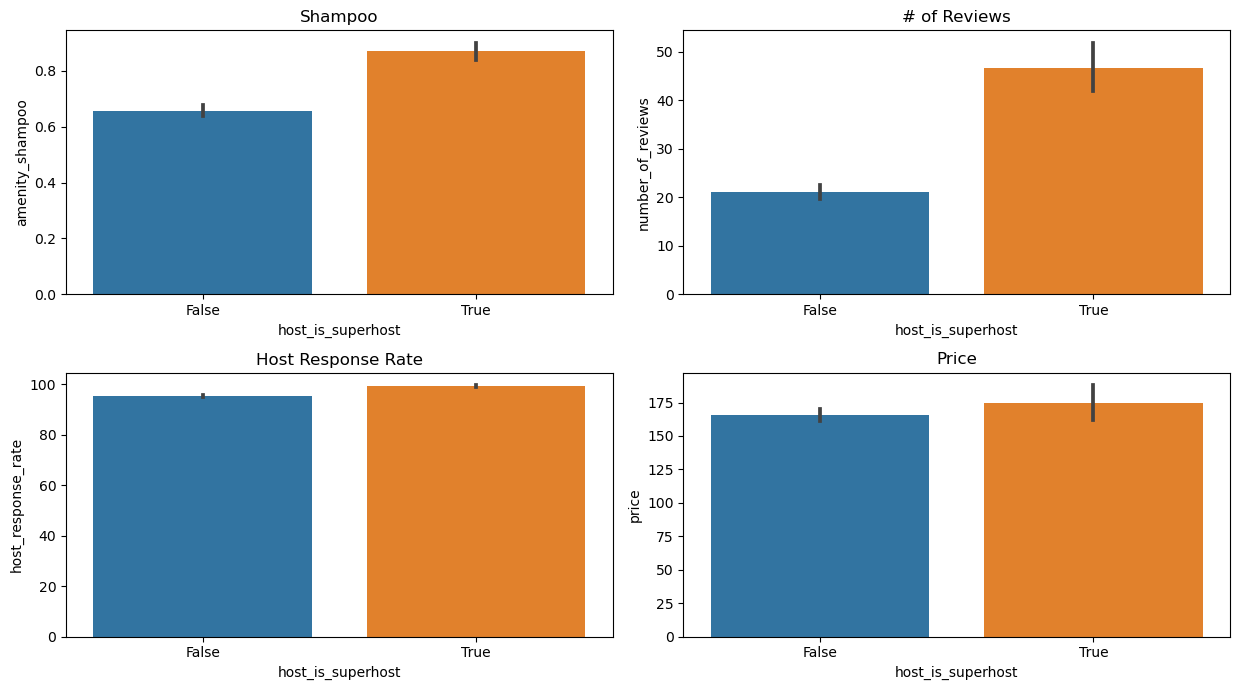

In [22]:
# Explore significant features
plt.subplots(figsize=(12.5, 7))

plt.subplot(221)
sns.barplot(data=df_listings,y="amenity_shampoo",x="host_is_superhost")
plt.title("Shampoo")

plt.subplot(222)
sns.barplot(data=df_listings,y="number_of_reviews",x="host_is_superhost")
plt.title("# of Reviews")

plt.subplot(223)
sns.barplot(data=df_listings,y="host_response_rate",x="host_is_superhost")
plt.title("Host Response Rate")

plt.subplot(224)
sns.barplot(data=df_listings,y="price",x="host_is_superhost")
plt.title("Price")
plt.tight_layout();


**Do "superhosts" enhance the guest experience?**

In comparing super hosts to others, amenities stood out as key differences. Surprisingly, 47% of significant features were amenities. Most of the ameneties that made the cut had to do with convenience and safety for short-term stays, like 'wireless_internet', 'free_parking', 'smoke_detector', 'essentials', and 'shampoo'. Amenities like fireplace, doorman, kitchen, and gym weren't important. I guess people aren't trying to stay fit on vacation lol.

When analyzing some of the significant features more closely we saw a couple of insights. 

Super hosts often get more and better reviews than other hosts, likely because they respond quickly and focus on safety, including verifying themselves and their guests on various platforms. And despite the high quality of super hosts' properties, they don't necessarily charge more. 

To conclude, the answer to are first question is a clear yes! Booking with super hosts can give you a better stay without extra costs. That means they're likely in higher demand and you should book them earlier.

## 3.3 What features have the most influence on the success of an Airbnb listing from an investor's standpoint?

In [23]:
# Create the metric and named it "performance"
df_listings['performance'] = df_listings.reviews_per_month * df_listings.review_scores_rating

# Drop host and review related features
drop_features = [f for f in df_listings.columns.values if 'review' in f or 'host' in f]

In [24]:
X = df_listings.drop(drop_features+['performance'], axis=1).select_dtypes(exclude='object')
y = df_listings.performance

In [25]:
model, X_train, X_test, y_train, y_test = \
    func.create_regression_mod(X, y)

# Score model
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
print("r-squared score was {} on {} training values".format(train_score, X_train.shape[0]))
print("r-squared score was {} on {} test values".format(test_score, X_test.shape[0]))

r-squared score was 0.31142917835407014 on 1897 training values
r-squared score was 0.2370523045194507 on 813 test values


In [26]:
### Get feature coefficients
coef_df = func.coef_weights(model.coef_, X_train)

In [27]:
coef_df.sort_values('abs_coefs',ascending=False).head(20).style.bar(subset='coefs', align='zero', color=['#d65f5f', '#5fba7d'])

,est_int,coefs,abs_coefs
14,instant_bookable,100.233637,100.233637
33,amenity_air_conditioning,76.893374,76.893374
16,require_guest_phone_verification,-71.818108,71.818108
47,amenity_24-hour_check-in,56.339224,56.339224
70,bed_type_Airbed,-55.971378,55.971378
64,property_type_Other,-53.931577,53.931577
43,amenity_gym,-50.443854,50.443854
15,require_guest_profile_picture,48.302621,48.302621
56,property_type_Boat,-48.220861,48.220861
19,amenity_kitchen,-45.817548,45.817548


In [28]:
X_train

,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,weekly_price,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,is_location_exact,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,amenity_tv,amenity_wireless_internet,amenity_kitchen,amenity_free_parking_on_premises,amenity_pets_live_on_this_property,amenity_dog(s),amenity_heating,amenity_family/kid_friendly,amenity_washer,amenity_dryer,amenity_smoke_detector,amenity_fire_extinguisher,amenity_essentials,amenity_shampoo,amenity_laptop_friendly_workspace,amenity_internet,amenity_air_conditioning,amenity_pets_allowed,amenity_carbon_monoxide_detector,amenity_lock_on_bedroom_door,amenity_hangers,amenity_hair_dryer,amenity_iron,amenity_cable_tv,amenity_first_aid_kit,amenity_safety_card,amenity_gym,amenity_breakfast,amenity_indoor_fireplace,amenity_cat(s),amenity_24-hour_check-in,amenity_buzzer/wireless_intercom,amenity_elevator_in_building,amenity_doorman,has_weekly_price,has_security_deposit,has_cleaning_fee,property_type_Apartment,property_type_Bed & Breakfast,property_type_Boat,property_type_Camper/RV,property_type_Condominium,property_type_Dorm,property_type_Entire Floor,property_type_Guesthouse,property_type_House,property_type_Loft,property_type_Other,property_type_Townhouse,property_type_Villa,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30
0,-0.335496,0.858415,-0.584860,-0.424441,-0.323870,-0.584891,-0.591640,-0.568962,-0.247317,-1.321566,-0.637725,-0.120321,-0.022829,True,False,False,False,True,True,True,False,True,False,True,False,True,True,True,True,True,True,False,True,True,False,True,False,True,True,True,True,True,False,False,False,False,True,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False
1,0.264934,0.647335,-1.121877,-0.424441,-1.639463,-0.584891,0.042542,-0.045280,-0.014529,-0.432870,1.214496,0.143398,-0.023310,True,False,False,False,False,True,True,False,False,False,True,True,True,True,True,False,True,False,False,False,True,False,True,False,True,False,True,False,True,True,True,False,False,False,False,False,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False
2,-1.200297,1.164256,-0.584860,2.521286,-0.323870,-0.584891,-0.582708,-0.560261,-0.247317,0.455826,0.420687,-0.252180,-0.022829,False,False,False,False,False,True,False,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,True,False,False,False
3,0.608404,-1.350225,-1.121877,-0.424441,-0.323870,-0.584891,-0.939994,-1.150167,-0.247317,-0.432870,-0.637725,1.593849,-0.023299,True,False,False,False,False,True,True,False,False,False,True,False,False,False,True,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False
4,0.434929,0.840884,0.489176,1.539377,0.991723,0.338954,2.096934,2.058597,1.382199,-0.432870,-0.637725,-0.120321,-0.022829,True,False,False,False,True,True,True,False,True,True,True,True,True,True,True,True,True,True,False,True,True,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,True,False,False,Fals